# 1.MORDM OPTIMIZATION

# 1.1 Generate random policies

In [1]:
import pandas as pd
import numpy as np

from ema_workbench import load_results
from ema_workbench import Scenario

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

In [2]:
# load the basecase results
experiments, outcomes = load_results('../results/basecase_results.tar.gz') 
outcomes_df = pd.DataFrame.from_dict(outcomes)

In [3]:
# load the Series which defines which are the experiments within the established threshold in the first part
y3 = pd.read_csv('../results/boolean_worst_scenarios.csv').iloc[:, 1:]

# Convert Series to a list
y = np.array(y3).squeeze()

In [4]:
# Filter out experiments which obey the established threshold
experiments_of_interest = experiments.loc[y]
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

In [5]:
# function to aggregate over time and locations
def aggregate_df(df):
    df_aggregate_time = pd.DataFrame()
    df_aggregate_time_location = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    step = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in step]

            df_aggregate_time_location[metric + ' time aggregate'] = df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[location + '_' + metric + ' time aggregate'] = df[columns].sum(axis=1)
            
            columns_locations = [location + '_' + metric + ' time aggregate' for location in locations]
            df_aggregate_time_location[metric + ' time location aggregate'] = df_aggregate_time[columns_locations].sum(axis=1)
                    

    return df_aggregate_time, df_aggregate_time_location

In [6]:
# Aggregate the outcome values
df_agg_t, df_agg_tl = aggregate_df(outcomes_df)

In the next step we want to select the worst case scnearios in order to optimize over them. For this, we rank all the different columns in the outcomes dataframe from highesto to lowest value. Then, we sum up the rank number and chose the scenarios which have the highest rank, i.e. the ones that perform the worst.

In [7]:
# Given that we're ranking on the base case, the dike investment costs are zero. Therfore, we drop those columns
dike_inv = ['A.1_Dike Investment Costs time aggregate', 'A.2_Dike Investment Costs time aggregate', 
            'A.3_Dike Investment Costs time aggregate', 'A.4_Dike Investment Costs time aggregate', 'A.5_Dike Investment Costs time aggregate']

df_agg_t.drop(columns=dike_inv, inplace=True)

In [8]:
# We rank each column and sum over each row value to obtain the rank of each scenario
rank_df = pd.DataFrame()
for column in df_agg_t.columns:
    rank_df[column] = df_agg_t[column].rank()

rank_df['Final rank'] = rank_df.sum(axis=1)

In [9]:
# In order to sort out the values for the top 5 worst scenarios, we retrieve their index to then filter them out from the experiments 
worst_5_df = rank_df.sort_values(by='Final rank',ascending=False).head()
worst_5_ind = list(worst_5_df.index)

# Finally, we filter the worst scenarios out and only get back the first 19 columns, which correspond to the uncertainty values in each scenario
scenarios_df = experiments_of_interest.iloc[worst_5_ind,:19]
indexes_scenarios = scenarios_df.index.to_list()
indexes_scenarios

[3794, 2761, 1322, 4347, 1009]

Now that we have the values of the uncertainties that correspond to the top 5 worst case scenarios, we specify them in the workbench and perform Multi-Scenario MORDM. ...

In [10]:
# Specify the scenarios in the workbench
scenarios = [Scenario(f"{index}", **row) for index, row in scenarios_df.iterrows()]

In [11]:
# Import the maximum and minimum values found across performing experiments for 100 policies across 400 scenarios
import pickle
with open('../results/min_max_range_basecase.pickle', 'rb') as f:
    max_range_bc, min_range_bc = pickle.load(f)
with open('../results/min_max_range_randompolicies.pickle', 'rb') as f:
    max_range_rp, min_range_rp = pickle.load(f)

In [12]:
max_range = pd.concat([max_range_bc, max_range_rp], axis=1)
min_range = pd.concat([min_range_bc, min_range_rp], axis=1)

In [13]:
max_range = max_range.max(axis=1)
min_range = min_range.min(axis=1)
max_range.drop(labels=['RfR Total Costs time aggregate'], inplace=True)
min_range.drop(labels=['RfR Total Costs time aggregate'], inplace=True)

In [14]:
max_range

Expected Annual Damage time location aggregate       6.790428e+09
Dike Investment Costs time location aggregate        9.334020e+08
Expected Number of Deaths time location aggregate    5.855678e+00
Expected Evacuation Costs time aggregate             1.246373e+05
dtype: float64

In [15]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from dike_model_function import DikeNetwork  # @UnresolvedImport

def sum_over(*args):
    return sum(args)

def get_model_for_problem_formulation_altered(min_range, max_range):
    ''' Prepare DikeNetwork in a way it can be input in the EMA-workbench.
    Specify uncertainties, levers and problem formulation.
    
    We only consider what is originally labelled as problem formulation 2, but without Rfr costs as an outcome. 
    Additionally, we incorpare the ranges across which we consider the outcomes to be within.
    '''
    # Load the model:
    function = DikeNetwork()
    # workbench model:
    dike_model = Model('dikesnet', function=function)

    # Uncertainties and Levers:
    # Specify uncertainties range:
    Real_uncert = {'Bmax': [30, 350], 'pfail': [0, 1]}  # m and [.]
    # breach growth rate [m/day]
    cat_uncert_loc = {'Brate': (1., 1.5, 10)}

    cat_uncert = {'discount rate {}'.format(n): (1.5, 2.5, 3.5, 4.5)
                    for n in function.planning_steps}
    
    Int_uncert = {'A.0_ID flood wave shape': [0, 132]}
    # Range of dike heightening:
    dike_lev = {'DikeIncrease': [0, 10]}    # dm

    # Series of five Room for the River projects:
    rfr_lev = ['{}_RfR'.format(project_id) for project_id in range(0, 5)]

    # Time of warning: 0, 1, 2, 3, 4 days ahead from the flood
    EWS_lev = {'EWS_DaysToThreat': [0, 4]}  # days

    uncertainties = []
    levers = []

    for uncert_name in cat_uncert.keys():
        categories = cat_uncert[uncert_name]
        uncertainties.append(CategoricalParameter(uncert_name, categories))

    for uncert_name in Int_uncert.keys():
        uncertainties.append(IntegerParameter(uncert_name, 
                                              Int_uncert[uncert_name][0],
                                              Int_uncert[uncert_name][1]))    

    # RfR levers can be either 0 (not implemented) or 1 (implemented)
    for lev_name in rfr_lev:
        for n in function.planning_steps:
            lev_name_ = '{} {}'.format(lev_name, n)
            levers.append(IntegerParameter(lev_name_, 0, 1))

    # Early Warning System lever
    for lev_name in EWS_lev.keys():
        levers.append(IntegerParameter(lev_name, EWS_lev[lev_name][0],
                                       EWS_lev[lev_name][1]))
    
    for dike in function.dikelist:
        # uncertainties in the form: locationName_uncertaintyName
        for uncert_name in Real_uncert.keys():
            name = "{}_{}".format(dike, uncert_name)
            lower, upper = Real_uncert[uncert_name]
            uncertainties.append(RealParameter(name, lower, upper))

        for uncert_name in cat_uncert_loc.keys():
            name = "{}_{}".format(dike, uncert_name)
            categories = cat_uncert_loc[uncert_name]
            uncertainties.append(CategoricalParameter(name, categories))

        # location-related levers in the form: locationName_leversName
        for lev_name in dike_lev.keys():
            for n in function.planning_steps:
                name = "{}_{} {}".format(dike, lev_name, n)
                levers.append(IntegerParameter(name, dike_lev[lev_name][0],
                                           dike_lev[lev_name][1]))

    # load uncertainties and levers in dike_model:
    dike_model.uncertainties = uncertainties
    dike_model.levers = levers

    # Problem formulations:
    # Outcomes are all costs, thus they have to minimized:
    direction = ScalarOutcome.MINIMIZE

    variable_names = []
    variable_names_ = []
    variable_names__ = []        
    variable_names___ = []
    variable_names____ = []

    for n in function.planning_steps:
        variable_names.extend(['{}_Expected Annual Damage {}'.format(dike, n)
                                     for dike in function.dikelist])
        variable_names_.extend(['{}_Dike Investment Costs {}'.format(dike, n)
                                  for dike in function.dikelist])
        variable_names__.extend(['RfR Total Costs {}'.format(n)])       
        variable_names___.extend(['Expected Evacuation Costs {}'.format(n)])
        variable_names____.extend(['{}_Expected Number of Deaths {}'.format(dike, n)
                                     for dike in function.dikelist])

    dike_model.outcomes = [
            ScalarOutcome('Expected Annual Damage',
                      variable_name=[var for var in variable_names],
                      function=sum_over, kind=direction, expected_range=(min_range[max_range.index[0]], max_range[max_range.index[0]])),

            ScalarOutcome('Dike Investment Costs',
                      variable_name=[var for var in variable_names_],
                      function=sum_over, kind=direction, expected_range=(min_range[max_range.index[1]], max_range[max_range.index[1]])),

            ScalarOutcome('Evacuation Costs',
                      variable_name=[var for var in variable_names___],
                      function=sum_over, kind=direction, expected_range=(min_range[max_range.index[3]], max_range[max_range.index[3]])),

            ScalarOutcome('Expected Number of Deaths',
                      variable_name=[var for var in variable_names____],
                      function=sum_over, kind=direction, expected_range=(min_range[max_range.index[2]], max_range[max_range.index[2]]))]
        
    return dike_model, function.planning_steps

In [16]:
# dike_model, planning_steps = get_model_for_problem_formulation_altered(2)

# annual_dmg_var = ['A.1_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2',
#                    'A.2_Expected Annual Damage 0', 'A.2_Expected Annual Damage 1', 'A.2_Expected Annual Damage 2',
#                    'A.3_Expected Annual Damage 0', 'A.3_Expected Annual Damage 1', 'A.3_Expected Annual Damage 2',
#                    'A.4_Expected Annual Damage 0', 'A.4_Expected Annual Damage 1', 'A.4_Expected Annual Damage 2',
#                    'A.5_Expected Annual Damage 0', 'A.5_Expected Annual Damage 1', 'A.5_Expected Annual Damage 2']

# deaths_var = ['A.1_Expected Number of Deaths 0', 'A.1_Expected Number of Deaths 1', 'A.1_Expected Number of Deaths 2',
#                    'A.2_Expected Number of Deaths 0', 'A.2_Expected Number of Deaths 1', 'A.2_Expected Number of Deaths 2',
#                    'A.3_Expected Number of Deaths 0', 'A.3_Expected Number of Deaths 1', 'A.3_Expected Number of Deaths 2',
#                    'A.4_Expected Number of Deaths 0', 'A.4_Expected Number of Deaths 1', 'A.4_Expected Number of Deaths 2',
#                    'A.5_Expected Number of Deaths 0', 'A.5_Expected Number of Deaths 1', 'A.5_Expected Number of Deaths 2']

# dikes_var= ['A.1_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2',
#                  'A.2_Dike Investment Costs 0', 'A.2_Dike Investment Costs 1', 'A.2_Dike Investment Costs 2',
#                  'A.3_Dike Investment Costs 0', 'A.3_Dike Investment Costs 1', 'A.3_Dike Investment Costs 2',
#                  'A.4_Dike Investment Costs 0', 'A.4_Dike Investment Costs 1', 'A.4_Dike Investment Costs 2',
#                  'A.5_Dike Investment Costs 0', 'A.5_Dike Investment Costs 1', 'A.5_Dike Investment Costs 2']

# rfr_costs_var = ['RfR Total Costs 0', 'RfR Total Costs 1', 'RfR Total Costs 2']

# evac_costs_var = ['Expected Evacuation Costs 0','Expected Evacuation Costs 1', 'Expected Evacuation Costs 2']


# dike_model.outcomes = [ScalarOutcome('Expected Annual Damage', variable_name=annual_dmg_var, kind=ScalarOutcome.MINIMIZE, function=sum_over,
#                                      expected_range=(min_range[max_range.index[0]], max_range[max_range.index[0]])),
#                        ScalarOutcome('Dike Investment Costs', variable_name=dikes_var, kind=ScalarOutcome.MINIMIZE, function=sum_over,
#                                      expected_range=(min_range[max_range.index[1]], max_range[max_range.index[1]])),
#                        ScalarOutcome('Evacuation Costs', variable_name=evac_costs_var, kind=ScalarOutcome.MINIMIZE, function=sum_over,
#                                     expected_range=(min_range[max_range.index[3]], max_range[max_range.index[3]])),
#                        ScalarOutcome('Expected Number of Deaths', variable_name=deaths_var, kind=ScalarOutcome.MINIMIZE, function=sum_over,
#                                     expected_range=(min_range[max_range.index[2]], max_range[max_range.index[2]]))]


# Initialise the altered formulation
dike_model, planning_steps = get_model_for_problem_formulation_altered(min_range,max_range)


deaths = ['Expected Number of Deaths']

max_num_deaths = 0.00001

# Adding the constraint for Room for the total number of deaths.
constraints = [Constraint("Max number of deaths", outcome_names=deaths,
                          function=lambda x:max(0, x-max_num_deaths))]


In [17]:
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=['A.1_Expected Annual Damage 0', 'A.2_Expected Annual Damage 0', 'A.3_Expected Annual Damage 0', 'A.4_Expected Annual Damage 0', 'A.5_Expected Annual Damage 0', 'A.1_Expected Annual Damage 1', 'A.2_Expected Annual Damage 1', 'A.3_Expected Annual Damage 1', 'A.4_Expected Annual Damage 1', 'A.5_Expected Annual Damage 1', 'A.1_Expected Annual Damage 2', 'A.2_Expected Annual Damage 2', 'A.3_Expected Annual Damage 2', 'A.4_Expected Annual Damage 2', 'A.5_Expected Annual Damage 2'], function=<function sum_over at 0x000001D7F97B5670>)
ScalarOutcome('Dike Investment Costs', variable_name=['A.1_Dike Investment Costs 0', 'A.2_Dike Investment Costs 0', 'A.3_Dike Investment Costs 0', 'A.4_Dike Investment Costs 0', 'A.5_Dike Investment Costs 0', 'A.1_Dike Investment Costs 1', 'A.2_Dike Investment Costs 1', 'A.3_Dike Investment Costs 1', 'A.4_Dike Investment Costs 1', 'A.5_Dike Investment Costs 1', 'A.1_Dike Investment Costs 2', 'A.2_Dike Investm

In [18]:
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [19]:
# perform the analysis
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import Constraint
from ema_workbench import SequentialEvaluator


convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
                       EpsilonProgress()]

nfe = 10000
results_deep = []
convergence_all = []


#We define the epsilons as a 100th part of the maximum value of the outcome
for scenario in scenarios:
    with SequentialEvaluator(dike_model) as evaluator:
        results_runs, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                        epsilons=[0.1, 0.1, 0.1, 0.0001],
                                        convergence=convergence_metrics, reference=scenario,
#                                        constraints=constraints
                                                      )
                                        
        
        results_deep.append(results_runs)
        convergence_all.append(convergence)

[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 500/10000 nfe
[MainProcess/INFO] generation 10: 1000/10000 nfe
[MainProcess/INFO] generation 15: 1499/10000 nfe
[MainProcess/INFO] generation 20: 1997/10000 nfe
[MainProcess/INFO] generation 25: 2495/10000 nfe
[MainProcess/INFO] generation 30: 2990/10000 nfe
[MainProcess/INFO] generation 35: 3488/10000 nfe
[MainProcess/INFO] generation 40: 3987/10000 nfe
[MainProcess/INFO] generation 45: 4482/10000 nfe
[MainProcess/INFO] generation 50: 4981/10000 nfe
[MainProcess/INFO] generation 55: 5477/10000 nfe
[MainProcess/INFO] generation 60: 5970/10000 nfe
[MainProcess/INFO] generation 65: 6456/10000 nfe
[MainProcess/INFO] generation 70: 6938/10000 nfe
[MainProcess/INFO] generation 75: 7431/10000 nfe
[MainProcess/INFO] generation 80: 7924/10000 nfe
[MainProcess/INFO] generation 85: 8421/10000 nfe
[MainProcess/INFO] generation 90: 8916/10000 nfe
[MainProcess/INFO] generation 95: 9406/10000 nfe
[MainProcess/INFO] generat

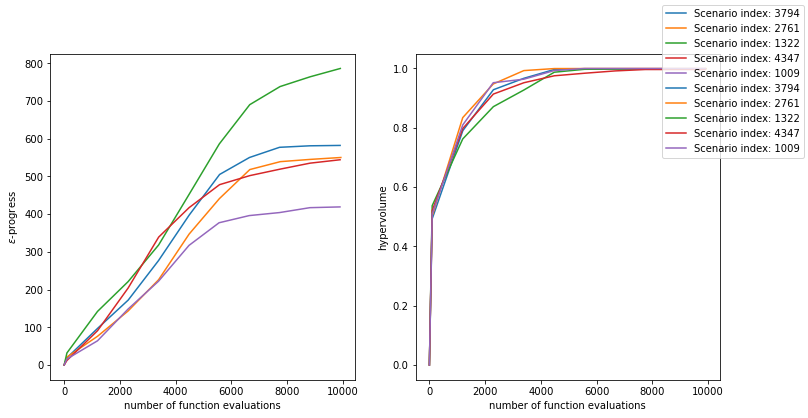

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot the results
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,6))

for i, con in enumerate(convergence_all):
    ax1.plot(con.nfe, con.epsilon_progress, label=f'Scenario index: {indexes_scenarios[i]}')
    ax2.plot(con.nfe, con.hypervolume, label=f'Scenario index: {indexes_scenarios[i]}')

ax1.set_ylabel('$\epsilon$-progress')
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.legend()
plt.show()

In [27]:
indexes_scenarios

[3794, 2761, 1322, 4347, 1009]

In [28]:
for a,b in enumerate(range(10,12)):
    print(a, b)

0 10
1 11


In [30]:
for i, result in enumerate(results_deep):
    result.to_csv(f'results/MORDM_10000nfe_scenario{indexes_scenarios[i]}_Hidde')

In [33]:
for i, result in enumerate(convergence_all):
    result.to_csv(f'results/convergence_10000nfe_scenario{indexes_scenarios[i]}_Hidde')

In [21]:
from ema_workbench.analysis import parcoords

colors = iter(sns.color_palette())

data = results_runs[0][0].iloc[:, 5::]
limits = parcoords.get_limits(data)

limits.loc[0, ['inertia', 'reliability']] = 1
limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()


KeyError: 0

# End of document

In [ ]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.000001) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1000) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Total_Investment_Costs = functools.partial(robustness, SMALLER, 150000000)#THOSE NUMBERS NEED TO BE SPECIFIED AGAINS




In [ ]:
from problem_formulation import get_model_for_problem_formulation

model = get_model_for_problem_formulation(1)

In [ ]:
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=200,               #500
                                            policies=4,
                                            uncertainty_sampling='mc')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

robustness_funcs = {"Expected Number of Deaths": Expected_Number_of_Deaths,
                    "Expected Annual Damage": Expected_Annual_Damage,
                    "Total Investment Costs": Total_Investment_Costs}

experiments, outcomes = results

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

# 1.2 Search for candidate solutions

the fundamental problem is fine tuning the robustness functions. To do this, rather than run optimizaitons many times, why not first generate a test set with a bunch of policies, apply robustness functions and visualize the results?

This gives us much faster feedback on reasonble cutoff values. 


In [ ]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)
nfe = int(1000)

In [ ]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)


In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios,              
                                            policies=100)

In [ ]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(data=data, y='Total Investment Costs')
plt.show()

In [ ]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Annual Damage')
ax.set_yscale('log')
plt.show()

In [ ]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Number of Deaths')
ax.set_yscale('log')
plt.show()

In [ ]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-5) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1e4) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Total_Investment_Costs = functools.partial(robustness, SMALLER, 6e8)#THOSE NUMBERS NEED TO BE SPECIFIED AGAINS


In [ ]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [ ]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1

ema_logging.log_to_stderr(ema_logging.INFO)

# there is a bit of problem with platypus, so using 1.1. gives 
# cleaner hypervolume results.
convergence = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 1.1]),
              EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios,nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons)
    
#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')    

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

This is a bit better but not much. 

Now, observe the following: you are using a domain criterion as your sole measure of robustness. That is, you look at the fraction of scenarios above or below a threshold. The costs however do not vary accross scenarios. Thus this objective can only be 0 or 1. This is not particularly useful for optimization. 

We might thus want to consider another metric for costs. Why not simply use the raw costs itself?


In [ ]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def costs(data):
    return data[0]/1e9 # makes numbers nicer
    
SMALLER = 'SMALLER'

Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1e-5) #not ok
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1e4) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Total_Investment_Costs = costs


In [ ]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

This already looks much nicer.

In [ ]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'Expected Number of Deaths':Expected_Number_of_Deaths,
         'Expected Annual Damage': Expected_Annual_Damage,
         'Total Investment Costs': Total_Investment_Costs}

robustnes_functions = [ScalarOutcome('fraction EA deaths', kind=MAXIMIZE, 
                             variable_name='Expected Number of Deaths', function=Expected_Number_of_Deaths),
                       ScalarOutcome('fraction EA damage', kind=MAXIMIZE, 
                             variable_name='Expected Annual Damage', function=Expected_Annual_Damage),
                       ScalarOutcome('investment costs', kind=MINIMIZE, # note that we have to minimize costs!
                             variable_name='Total Investment Costs', function=Total_Investment_Costs)]

In [ ]:
# we have to change the plausible max for total investment costs
convergence = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 3]),
              EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [ ]:
data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

# 1.3 Re-evaluate candidate solutions under uncertainty

In [ ]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

In [ ]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')

In [ ]:
from ema_workbench import save_results

save_results(results, 'MORO_reevaluation.tar.gz')

In [ ]:
policies.to_csv('moro polices.csv')

In [ ]:
import pandas as pd
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

In [ ]:

data = overall_robustness.loc[:, 
                              ['Expected Number of Deaths', 'Expected Annual Damage', 'Total Investment Costs']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()